In [1]:
#Importamos librerías que pueden sernos de utilidad
import pandas as pd
import numpy as np
#Si no posee geopandas, sacar el hashtag al siguiente comentario y realizar la instalación:
#!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#Si no posee wordcloud, sacar el hashtag al siguiente comentario y realizar la instalación:
#!pip install wordcloud
from wordcloud import WordCloud
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib.ticker import ScalarFormatter

#Configuramos la calidad de imagen
plt.rcParams["figure.dpi"] = 120

#Abrimos archivos de datasets a usar
df1_2022 = pd.read_csv('A_INSCRITOS_PUNTAJES_PDT_2022_PUB_MRUN.csv', sep=';')
df1 = pd.read_csv('20230802_Matrícula_Ed_Superior_2022_PUBL_MRUN.csv', sep=';')

C:\Users\gmari\AppData\Local\Temp\ipykernel_1300\169434476.py:21: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('20230802_Matrícula_Ed_Superior_2022_PUBL_MRUN.csv', sep=';')


C:\Users\gmari\AppData\Local\Temp\ipykernel_1300\589859379.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['MRUN'] = df_2022['MRUN'].astype(int)
C:\Users\gmari\AppData\Local\Temp\ipykernel_1300\589859379.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['ANYO_PROCESO'] = df_2022['ANYO_PROCESO'].astype(int)
C:\Users\gmari\AppData\Local\Temp\ipykernel_1300\589859379.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

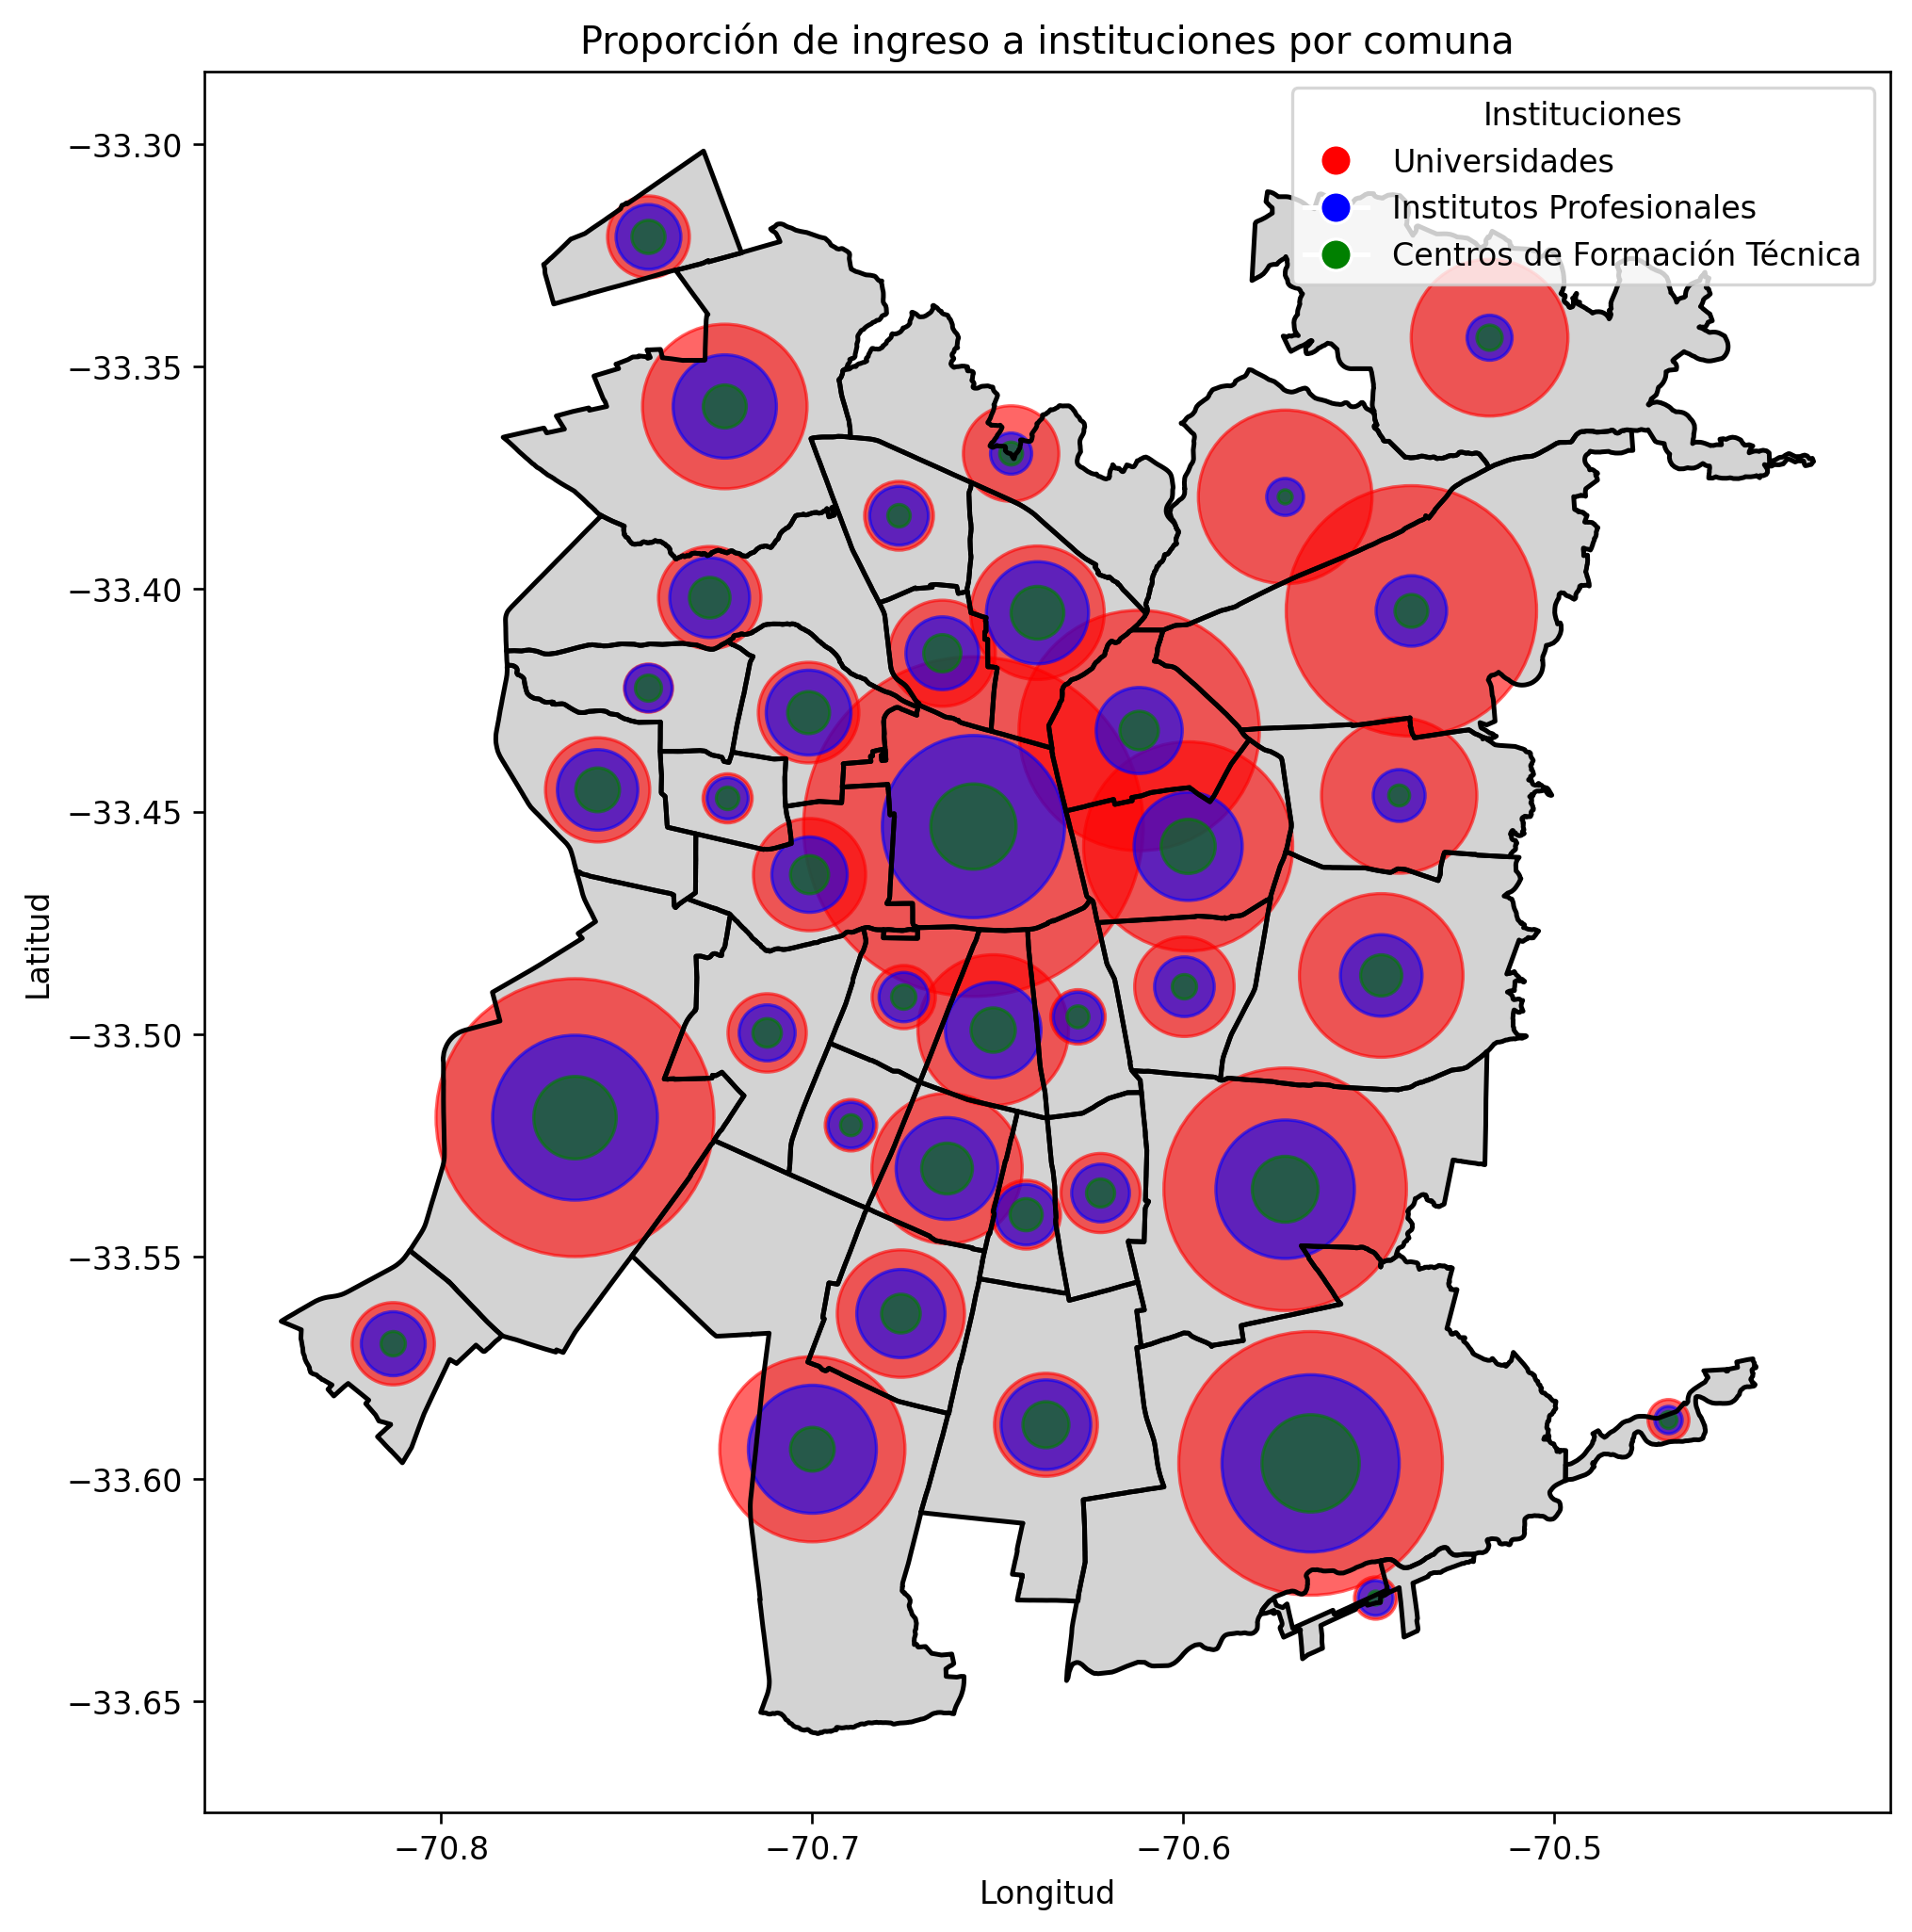

In [2]:
#Seleccionamos columnas importantes para el trabajo
df_2022 = df1_2022[['MRUN', 'ANYO_PROCESO', 'CODIGO_REGION_EGRESO', 'NOMBRE_COMUNA_EGRESO', 'CODIGO_COMUNA_EGRESO']]
df = df1[['mrun', 'anio_ing_carr_ori', 'tipo_inst_1']]

#Cambiamos los valores a números para trabajar con mayor facilidad
df_2022['MRUN'] = df_2022['MRUN'].astype(int)
df_2022['ANYO_PROCESO'] = df_2022['ANYO_PROCESO'].astype(int)
df_2022['CODIGO_REGION_EGRESO'] = df_2022['CODIGO_REGION_EGRESO'].astype(int)

#Cambiamos nombres de columnas del dataframe con el año de ingreso e institución
df = df.rename(columns={'mrun': 'MRUN', 'anio_ing_carr_ori': 'ANYO_INGRESO', 'tipo_inst_1': 'INSTITUCION'})

#Seleccionamos las filas a usar, que corresponden al año 2022
df2 = df.loc[df['ANYO_INGRESO'] == 2022]

#Juntamos ambos datasets a partir del identificador, para seleccionar aquellos alumnos que se encuentran dentro del dataset de matriculas y de PDT
datos = pd.merge(df_2022, df2, on='MRUN', how='inner')
datos = datos.drop_duplicates()

#Eliminamos ceros y datos vacíos
datos = datos.replace(0, np.nan)
datos = datos.dropna()

#Seleccionamos la Región Metropolitana
datos = datos.loc[datos['CODIGO_REGION_EGRESO'] == 13]
datos['CODIGO_COMUNA_EGRESO'] = datos['CODIGO_COMUNA_EGRESO'].astype(int)

#Abrimos nuestro geopanda con el mapa de Santiago
urban_stgo = gpd.read_file('urban_stgo_border.shp')
urban_stgo = urban_stgo.set_crs('EPSG:4326')
urban_stgo = urban_stgo.to_crs('EPSG:4326')

#Con el archivo json buscamos los límites de cada comuna para ubicar las coordenadas
comunas = gpd.read_file('urban_comunas.json')

#Cambiamos los valores a números para trabajar con mayor facilidad
comunas['REGION'] = comunas['REGION'].astype(int)
comunas['PROVINCIA'] = comunas['PROVINCIA'].astype(int)
comunas['COMUNA'] = comunas['COMUNA'].astype(int)

#Realizamos la intersección entre el mapa y los límites entre comunas
urban_comunas = gpd.overlay(comunas, urban_stgo, how='intersection')

#Contamos la cantidad de egresados por comuna
egresados_por_comuna = datos.groupby(['CODIGO_COMUNA_EGRESO', 'INSTITUCION']).size().reset_index(name='count')

#Unimos el conteo con cada comuna
gdf = urban_comunas.merge(egresados_por_comuna, left_on='COMUNA', right_on='CODIGO_COMUNA_EGRESO')

#Definimos un color distinto para cada institución
colores = {
    'Universidades': 'red',
    'Institutos Profesionales': 'blue',
    'Centros de Formación Técnica': 'green'
}

#Creamos el gráfico
fig, ax = plt.subplots(figsize=(10, 10))

#Ubicamos las comunas
urban_comunas.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)

#Ubicamos los puntos según la cantidad e institución ingresada
instituciones_vistas = set() 

for institucion, color in colores.items():
    instituciones = gdf[gdf['INSTITUCION'] == institucion]
    
    for idx, row in instituciones.iterrows():
        geom = row.geometry
        count = row['count']
        
        #Ubicamos los puntos en el centro de la comuna
        centroid = geom.centroid
        ax.plot(centroid.x, centroid.y, 'o', markersize=np.sqrt(count)*1.5, color=color, alpha=0.6, 
                label=institucion if institucion not in instituciones_vistas else "")
        instituciones_vistas.add(institucion)

#Volvemos a plotear los límites de las comunas para asegurar visibilidad
urban_comunas.boundary.plot(ax=ax, linewidth=1.5, color='black')

#Creamos elementos de la leyenda
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=institucion) 
                   for institucion, color in colores.items()]

#Se crea la leyenda y muestra el gráfico
ax.legend(handles=legend_elements, title="Instituciones")
plt.title("Proporción de ingreso a instituciones por comuna")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

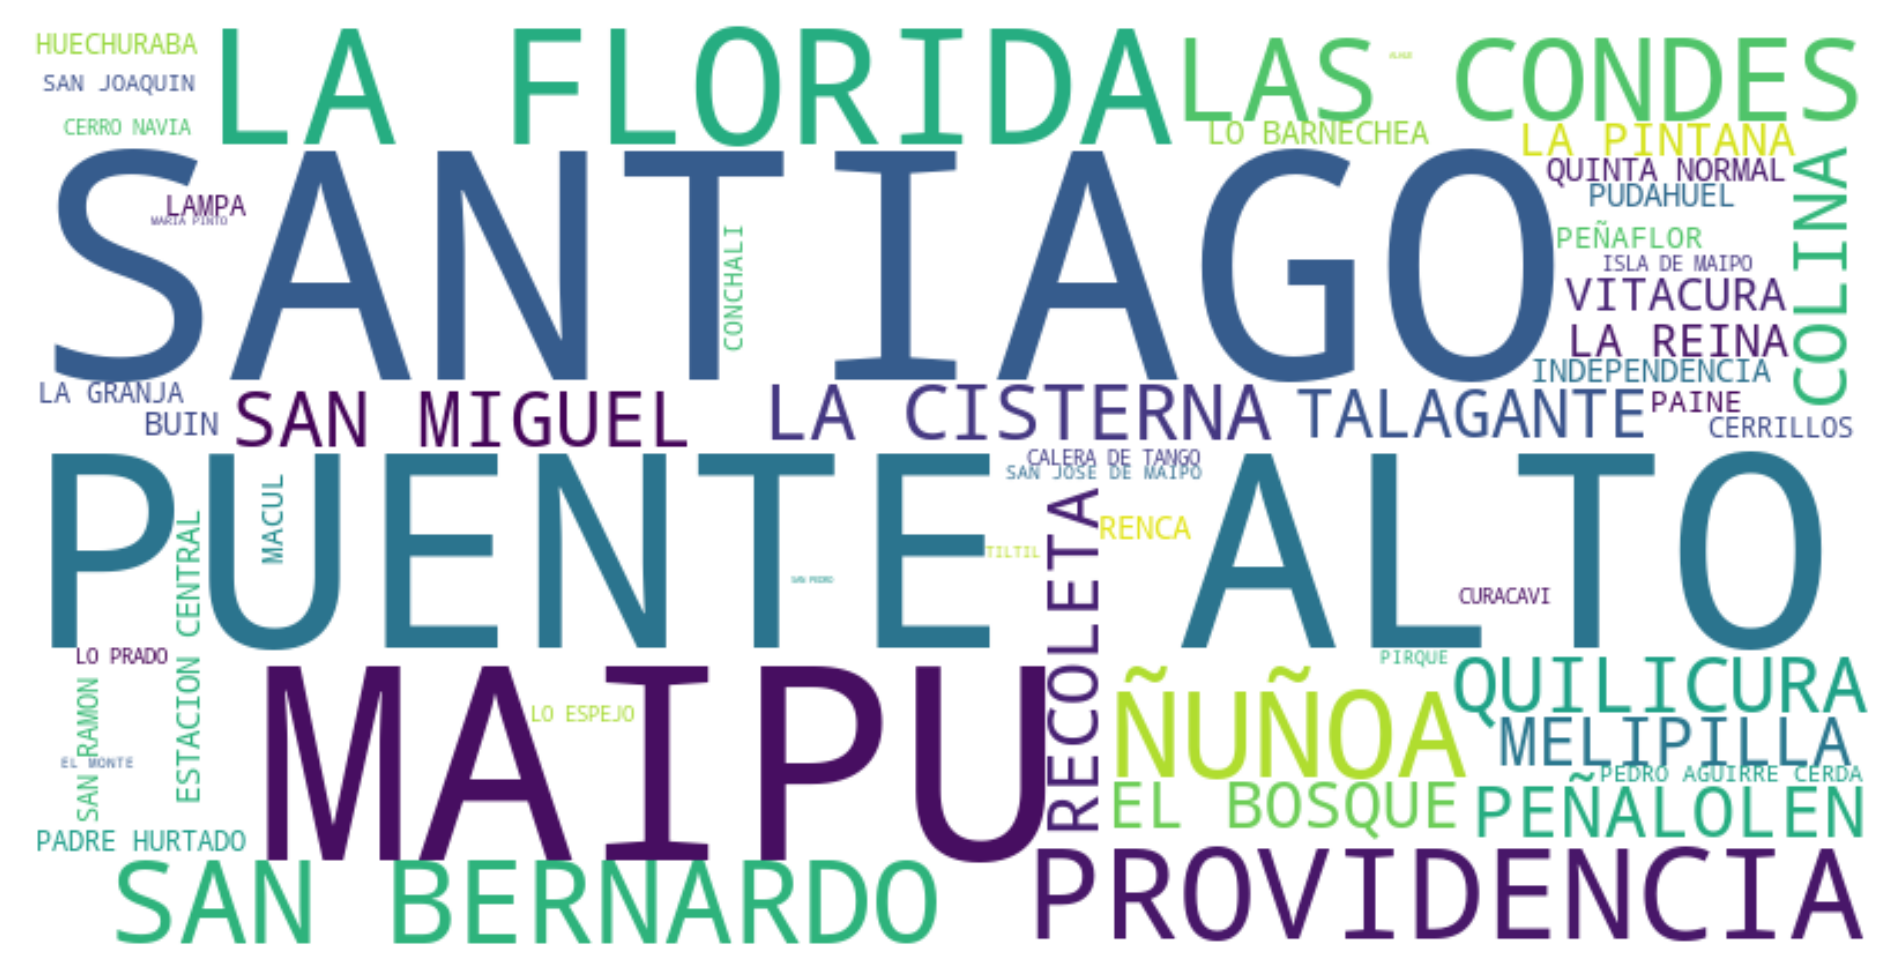

In [3]:
#Utilizamos la cantidad de personas que participaron en el proceso de admisión 2022 y seleccionamos la Región Metropolitana
df_2022 = df_2022.loc[df_2022['CODIGO_REGION_EGRESO'] == 13]
counts = df_2022['NOMBRE_COMUNA_EGRESO'].value_counts()

#Contamos la cantidad de veces que se repite cada comuna en el dataset
palabras = df_2022['NOMBRE_COMUNA_EGRESO'].value_counts().to_dict()

#Creamos el Word Cloud usando las frecuencias
wordcloud = WordCloud(width=800, height=400, background_color='white' ).generate_from_frequencies(palabras)

#Se presenta el gráfico
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ocultar los ejes
plt.show()